In [1]:
import os
import cv2
import time
import numpy as np
import mediapipe as mp
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                            mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                            mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)) 
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)) 

def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

DATASET

In [3]:
actions = np.array(['apa', 'hai', 'nama', 'hobi', 'saya', 'kamu', 'sehat', 'maaf', 'tolong', 'no_action'])

no_sequences = 60
sequence_length = 30
start_folder = 30

DATA_PATH = (r"C:\Users\ilham\Documents\SignLanguage\LSTM-Dataset")

In [4]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'apa': 0,
 'hai': 1,
 'nama': 2,
 'hobi': 3,
 'saya': 4,
 'kamu': 5,
 'sehat': 6,
 'maaf': 7,
 'tolong': 8,
 'no_action': 9}

Train Test

In [5]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), '{}_keypoints_{}.npy'.format(action, frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [6]:
X = np.array(sequences)

In [7]:
y = to_categorical(labels).astype(int)

In [8]:
print('X Shape:', X.shape)
print('y Shape:', y.shape)

X Shape: (600, 30, 258)
y Shape: (600, 10)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,stratify=y)

In [10]:
print('X_train Shape:',X_train.shape)
print('y_train Shape:',y_train.shape)
print('X_test Shape:',X_test.shape)
print('y_test Shape:',y_test.shape)

X_train Shape: (480, 30, 258)
y_train Shape: (480, 10)
X_test Shape: (120, 30, 258)
y_test Shape: (120, 10)


In [11]:
test_count_label = tf.reduce_sum(y_test, axis=0)
train_count_label = tf.reduce_sum(y_train, axis=0)

In [12]:
import pandas as pd

left = pd.DataFrame(train_count_label,columns=['train_count'])
right = pd.DataFrame(test_count_label,columns=['test_count'])
df = left.join(right)

actions_list = actions.tolist()

left = pd.DataFrame(actions_list,columns=['class_names'])
df = left.join(df)
df

,class_names,train_count,test_count
0,apa,48,12
1,hai,48,12
2,nama,48,12
3,hobi,48,12
4,saya,48,12
5,kamu,48,12
6,sehat,48,12
7,maaf,48,12
8,tolong,48,12
9,no_action,48,12


Text(0.5, 1.0, 'Distribution of Train & Test Data after train_test_split')

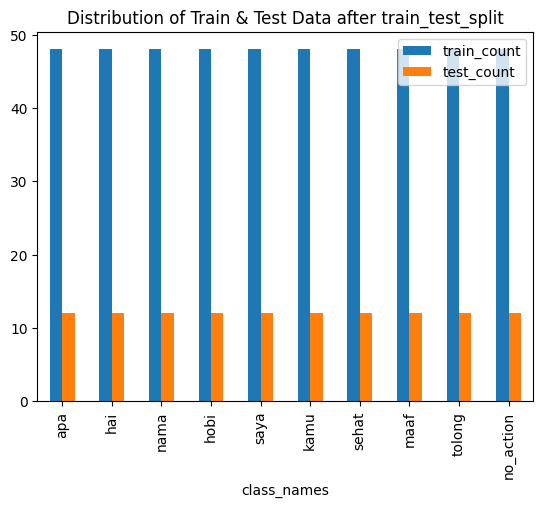

In [13]:
ax = df.plot.bar(x='class_names',rot=90)
ax.set_title('Distribution of Train & Test Data after train_test_split')

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import  Input, Flatten, Dense, LSTM, TimeDistributed
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import Callback

In [15]:
log_dir = os.path.join('Model')
tb_callback = TensorBoard(log_dir=log_dir)

In [16]:
class StopTrainingCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch > 50 and logs.get('loss') < 0.09 and (logs.get('accuracy') < 0.99 and logs.get('accuracy') > 0.88):
            print("Stopping training")
            self.model.stop_training = True
stop_callback = StopTrainingCallback()

In [17]:
lstm_input = Input(shape=(30, 258))

In [18]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False, activation='relu')) 
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [19]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, verbose=2, callbacks=[tb_callback, stop_callback])

Epoch 1/100
15/15 - 5s - loss: 1.9065 - accuracy: 0.2896 - val_loss: 1.5351 - val_accuracy: 0.4000 - 5s/epoch - 323ms/step
Epoch 2/100
15/15 - 1s - loss: 1.6666 - accuracy: 0.5396 - val_loss: 1.7386 - val_accuracy: 0.3417 - 942ms/epoch - 63ms/step
Epoch 3/100
15/15 - 1s - loss: 2.0267 - accuracy: 0.4437 - val_loss: 1.1911 - val_accuracy: 0.6167 - 924ms/epoch - 62ms/step
Epoch 4/100
15/15 - 1s - loss: 10.3857 - accuracy: 0.4271 - val_loss: 51.8484 - val_accuracy: 0.2417 - 941ms/epoch - 63ms/step
Epoch 5/100
15/15 - 1s - loss: 21.8857 - accuracy: 0.3438 - val_loss: 2.1746 - val_accuracy: 0.4417 - 938ms/epoch - 63ms/step
Epoch 6/100
15/15 - 1s - loss: 1.7554 - accuracy: 0.4375 - val_loss: 0.9780 - val_accuracy: 0.6333 - 945ms/epoch - 63ms/step
Epoch 7/100
15/15 - 1s - loss: 1.0606 - accuracy: 0.6000 - val_loss: 0.8347 - val_accuracy: 0.7417 - 951ms/epoch - 63ms/step
Epoch 8/100
15/15 - 1s - loss: 0.7816 - accuracy: 0.6938 - val_loss: 0.5036 - val_accuracy: 0.7333 - 953ms/epoch - 64ms/step

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            82688     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2

In [22]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [23]:
import pandas as pd   
hist_df = pd.DataFrame(history.history)
hist_df

,loss,accuracy,val_loss,val_accuracy
0,1.906469,0.289583,1.535101,0.400000
1,1.666562,0.539583,1.738647,0.341667
2,2.026736,0.443750,1.191123,0.616667
3,10.385730,0.427083,51.848392,0.241667
4,21.885689,0.343750,2.174617,0.441667
5,1.755413,0.437500,0.978032,0.633333
6,1.060649,0.600000,0.834716,0.741667
7,0.781576,0.693750,0.503622,0.733333
8,0.508821,0.785417,0.343588,0.900000
9,0.560374,0.762500,0.268028,0.883333


In [24]:
min_loss_epoch = hist_df[hist_df['loss']==min(hist_df['loss'])].index.values
min_loss = min(hist_df['loss'])
print('Index of Minimum Loss =',min_loss_epoch[0])
print('Minimum Loss =',round(min_loss,2))

Index of Minimum Loss = 44
Minimum Loss = 0.01


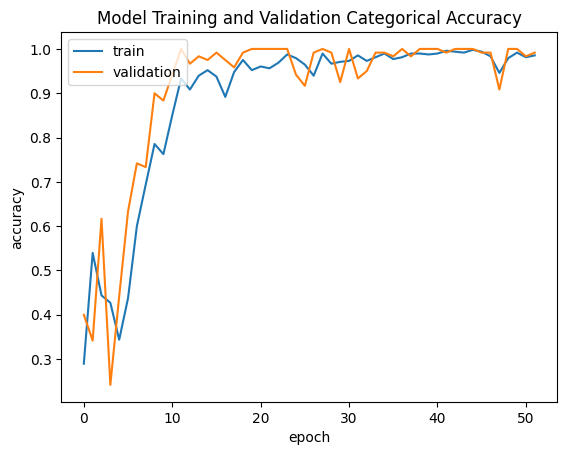

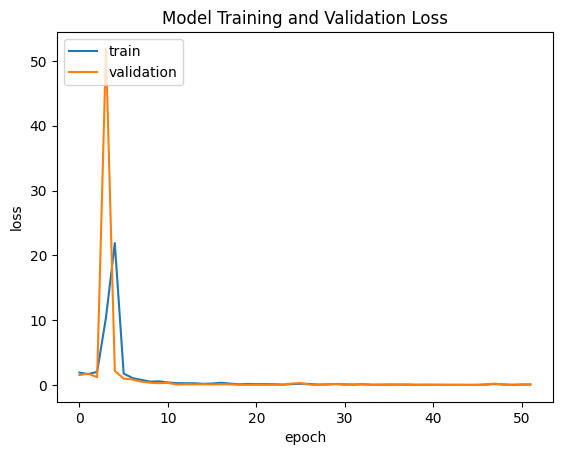

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Training and Validation Categorical Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [26]:
import time

start_time = time.time()
predictions = model.predict(X_test)
end_time = time.time()

latency = end_time - start_time
print(f"Latency: {latency} seconds")

4/4 [==============================] - 1s 19ms/step
Latency: 1.3209240436553955 seconds


Save and Reload Model

In [27]:
import os
from keras.models import load_model

save_folder = './Model'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

model.save(os.path.join(save_folder, 'Model-LSTM.h5'))

Make Prediction

In [28]:
res = model.predict(X_test)
actions[np.argmax(res[4])]

4/4 [==============================] - 0s 23ms/step


'sehat'

In [29]:
actions[np.argmax(y_test[4])]

'sehat'

Matrix and Accuracy

In [30]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
yhat = model.predict(X_test)

4/4 [==============================] - 0s 20ms/step


In [31]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [32]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[107,   1],
        [  0,  12]],

       [[108,   0],
        [  0,  12]],

       [[108,   0],
        [  0,  12]],

       [[108,   0],
        [  0,  12]],

       [[108,   0],
        [  0,  12]],

       [[108,   0],
        [  1,  11]],

       [[108,   0],
        [  0,  12]],

       [[108,   0],
        [  0,  12]],

       [[108,   0],
        [  0,  12]],

       [[108,   0],
        [  0,  12]]], dtype=int64)

In [33]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

4/4 [==============================] - 0s 27ms/step - loss: 0.0856 - accuracy: 0.9917
Test Loss: 0.08555348962545395
Test Accuracy: 0.9916666746139526


In [34]:
label_list = ['apa', 'hai', 'nama', 'hobi', 'saya', 'kamu', 'sehat', 'maaf', 'tolong', 'no_action']
label_list = list(label_map.keys())
label_list

['apa',
 'hai',
 'nama',
 'hobi',
 'saya',
 'kamu',
 'sehat',
 'maaf',
 'tolong',
 'no_action']

15/15 [==============================] - 0s 22ms/step
Train Overall Multiclassification Accuracy Score across all classes: 0.99


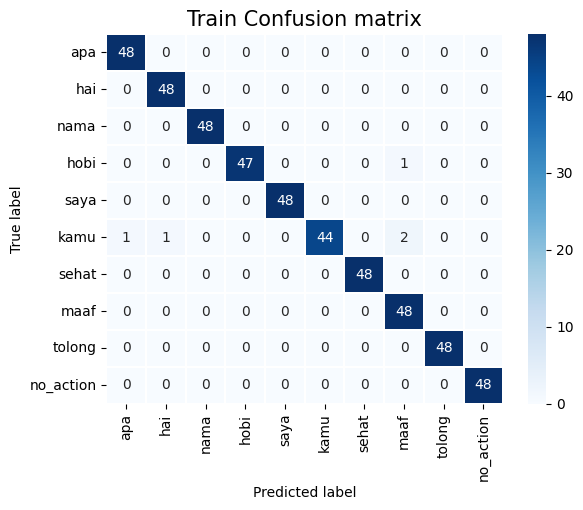

4/4 [==============================] - 0s 23ms/step
Test Overall Multiclassification Accuracy Score across all classes: 0.99


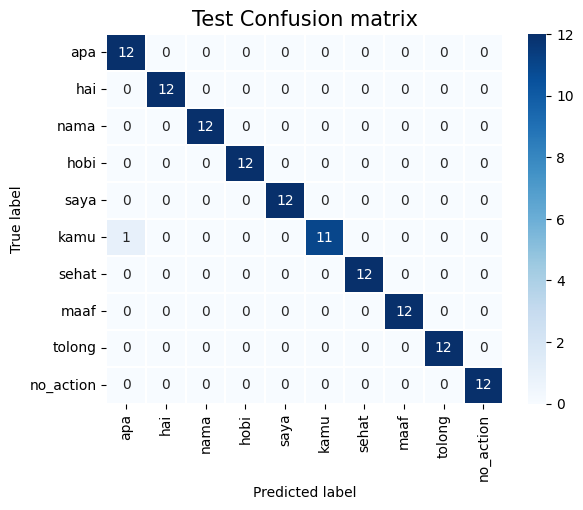

In [35]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def generate_confusion_matrix_accuracy(X,y,types):
    predictions = model.predict(X)
    y_true = np.argmax(y, axis=1)
    y_pred = np.argmax(predictions, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    print(f'{types} Overall Multiclassification Accuracy Score across all classes:',round(accuracy_score(y_true, y_pred),2))
    sns.heatmap(cm, xticklabels = label_list, yticklabels = label_list, annot = True, linewidths = 0.1, fmt='d',cmap='Blues')
    plt.title(f"{types} Confusion matrix", fontsize = 15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
generate_confusion_matrix_accuracy(X_train,y_train,'Train')
generate_confusion_matrix_accuracy(X_test,y_test,'Test')